# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 
### *** saraspagno@gmail.com,tirza.hanan@gmail.com ***

---
---


In [8]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
import matplotlib.pyplot as plt
from typing import Any

np.random.seed(42)

# Part 1 - Design the AdaBoost Algorithm

## 1.1 Theoretical Foundations

AdaBoost (Adaptive Boosting) is a sequential ensemble method that combines multiple **weak learners** into a single **strong classifier**.  
A weak learner is a model that performs only slightly better than random guessing.

Given training data $(x_i, y_i)$ with  
$$
y_i \in \{-1, +1\},
$$
AdaBoost maintains a set of weights $w_i^{(t)}$ over training samples and trains a weak classifier at each boosting round.

The final boosted classifier is:
$$
H_T(x) = \sum_{t=1}^{T} \alpha_t h_t(x),
\qquad
\hat{y}(x) = \text{sign}(H_T(x)).
$$

AdaBoost minimizes the **exponential loss**:
$$
L(H) = \sum_{i=1}^{n} \exp\big(-y_i H(x_i)\big),
$$
which leads to a closed-form update rule for $\alpha_t$.

## 1.2 Practical Design Considerations

### 1.2.1 Choice of Weak Learner

Following the lecture guidelines, we use  
$$
\text{DecisionTreeClassifier(max\_depth = 1)}
$$
i.e., a **decision stump**.  

Reasons:
- Stumps precisely match the theoretical model analyzed in class.
- They are fast, interpretable, and react strongly to weight changes.
- They support weighted training using `sample_weight`.

### 1.2.2 Weighted Training Strategy

At iteration $t$, the weak learner is trained using the weight distribution:
$$
w^{(t)} = \left(w_1^{(t)}, \dots, w_n^{(t)}\right),
$$
implemented through `sample_weight` in scikit-learn.

This ensures examples with larger weights contribute more to the training objective.

### 1.2.3 Label Representation

AdaBoost is defined for labels $\{-1,+1\}$.  
If the dataset uses $\{0,1\}$, we map:
$$
0 \mapsto -1,\qquad 1 \mapsto +1.
$$

### 1.2.4 Numerical Stability Measures

Practical precautions:
- Weighted error is clipped:
  $$
  \varepsilon_t \leftarrow \text{clip}(\varepsilon_t, 10^{-12}, 1 - 10^{-12}).
  $$
- If $ \varepsilon_t \geq 0.5 $:  
  the weak learner is not better than random → **stop early**.
- If $ \varepsilon_t = 0 $:  
  the stump is perfectly accurate → boosting can terminate.

These prevent exploding weights or division-by-zero.

### 1.2.5 Stopping Criteria

Boosting stops if any of these occurs:
1. Perfect classifier is found.  
2. Weak learner becomes no better than chance.  
3. Maximum number of rounds $T$ is reached (hyperparameter).

## 1.3 Full Algorithm Description

### 1.3.1 Initialization

$$
w_i^{(1)} = \frac{1}{n}, \quad i = 1,\dots,n.
$$

### 1.3.2 Boosting Iteration $t = 1, \dots, T$

**Step 1: Train weak classifier**

Train a stump $h_t(x)$ using sample weights $w^{(t)}$.

**Step 2: Compute weighted error**

$$
\varepsilon_t = \sum_{i=1}^{n} w_i^{(t)} \cdot \mathbf{1}[h_t(x_i) \neq y_i].
$$

**Step 3: Compute learner weight**

$$
\alpha_t = \frac{1}{2} \ln\left( \frac{1 - \varepsilon_t}{\varepsilon_t} \right).
$$

This weighs each learner by its accuracy.

**Step 4: Update example weights**

$$
w_i^{(t+1)} = \frac{w_i^{(t)} \cdot \exp(-\alpha_t y_i h_t(x_i))}{Z_t},
$$
where $Z_t = \sum_{i=1}^{n} w_i^{(t)} \cdot \exp(-\alpha_t y_i h_t(x_i))$ is the normalization factor ensuring $\sum_{i=1}^{n} w_i^{(t+1)} = 1$.

Misclassified examples ($y_i h_t(x_i) < 0$) receive an exponential *increase* in weight.

## 1.4 Hyperparameters

| Hyperparameter | Meaning | Impact |
|----------------|---------|--------|
| **n\_estimators (T)** | Maximum boosting rounds | Higher T → more expressive, but risk of overfitting |
| **base\_estimator** | Weak learner type | Stumps recommended for classical AdaBoost |
| **random\_state** | Reproducibility | Ensures deterministic experiments |
| **error clipping** | Stability mechanism | Prevents numeric overflow |
| **early stopping** | Stop when learner is no better than random | Avoids useless iterations |

## 1.5 Limitations

- **Highly sensitive to label noise**: due to exponential weight growth.  
- **Uses exponential loss**: strongly penalizes misclassified samples (outliers).  
- **Weak learners must be slightly better than random** ($\varepsilon < 0.5$).  
- **No built-in regularization**: unlike gradient boosting.  
- **Performance deteriorates with many outliers or overlapping classes**.

## 1.6 Use-Cases

Suitable for:
- Low-noise datasets.
- Problems where simple rules (stumps) can partition the space.
- Cases requiring interpretability.
- Situations where speed and simplicity are important.
- Medium-sized tabular datasets.

Less suitable for:
- High label-noise environments.
- Very high-dimensional or sparse data.
- Tasks requiring robustness to outliers.
- Large-scale industrial datasets (gradient boosting is preferable).

# Part 2 - Implementing the AdaBoost Algorithm

## 2.1 Implementation Details

Our implementation follows the AdaBoost.M1 procedure, with interface:

- `__init__(self, T)`
- `fit(self, X, y)`
- `predict(self, X)`

while allowing additional internal attributes for diagnostics and clarity.

### **Initialization:**
We store the required fields:

- `self.T`: maximum number of boosting rounds  
- `self.alphas`: weights of the weak learners  
- `self.models`: list of trained decision stumps  

Additionally, for analysis and debugging we maintain:

- `self.epsilons`: weighted error at each round  
- `self.weight_history`: full evolution of sample weights  
- `self.Z_history`: normalization constants  

### **Label Handling:**
The code supports datasets with labels in `{0,1}` or `{-1,+1}`.  
If `{0,1}` is detected, we convert them to `{-1,+1}` since AdaBoost’s weight update uses signed labels.

### **Base Weak Learner:**
We follow the classical AdaBoost setup and use: `DecisionTreeClassifier(max_depth=1, random_state=42)`

In [10]:
class AdaBoostCustom:
    def __init__(self, T):
        """
        Custom implementation of AdaBoost.M1 using decision stumps.

        Parameters
        ----------
        T : int
            Maximum number of boosting rounds.
        """
        self.T = T
        self.alphas = []
        self.models = []
        self.epsilons = []
        self.weight_history = []
        self.Z_history = []

    def fit(self, X, y):
        """
        Fit AdaBoost ensemble on data (X, y).

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data.
        y : ndarray of shape (n_samples,)
            Target labels in {0,1} or {-1,+1}.

        Returns
        -------
        self : AdaBoostCustom
            Returns self for method chaining.
        """
        X = np.asarray(X)
        y = np.asarray(y)

        if set[Any](np.unique(y)) == {0, 1}:
            y = 2 * y - 1
        elif set[Any](np.unique(y)) != {-1, 1}:
            raise ValueError("Labels must be in {0,1} or {-1,+1}.")

        n = len(X)
        w = np.ones(n) / n
        base_est = DecisionTreeClassifier(max_depth=1, random_state=42)

        self.alphas.clear()
        self.models.clear()
        self.epsilons.clear()
        self.weight_history.clear()
        self.Z_history.clear()

        for t in range(self.T):
            clf = clone(base_est)
            clf.fit(X, y, sample_weight=w)
            pred = clf.predict(X)

            incorrect = (pred != y).astype(float)
            eps = float(np.dot(w, incorrect))

            eps = np.clip(eps, 1e-12, 1 - 1e-12)

            if eps >= 0.5:
                break

            alpha = 0.5 * np.log((1 - eps) / eps)

            exponent = -alpha * y * pred
            exponent = np.clip(exponent, -700, 700)
            w = w * np.exp(exponent)

            Z = w.sum()
            if Z <= 0 or not np.isfinite(Z):
                break
            w = w / Z

            self.models.append(clf)
            self.alphas.append(alpha)
            self.epsilons.append(eps)
            self.weight_history.append(w.copy())
            self.Z_history.append(Z)

        return self

    def predict(self, X):
        """
        Predict labels for new samples.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input samples to predict.

        Returns
        -------
        pred : ndarray of shape (n_samples,)
            Predicted labels in {-1,+1}.
        """
        X = np.asarray(X)

        if len(self.models) == 0:
            raise ValueError("Model has not been fitted yet.")

        margin = np.zeros(X.shape[0])
        for alpha, clf in zip(self.alphas, self.models):
            margin += alpha * clf.predict(X)

        pred = np.sign(margin)
        pred[pred == 0] = 1

        return pred.astype(int)

In [ ]:
# Small sanity check (not for grading)
X, y = make_classification(
    n_samples=800, n_features=2, n_informative=2, n_redundant=0,
    class_sep=2.0, flip_y=0.0, random_state=0
)

y = 2 * y - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

model = AdaBoostCustom(T=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Estimators used: {len(model.models)}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")

alphas_fmt = [f"{a:.3f}" for a in model.alphas[:5]]
eps_fmt     = [f"{e:.4f}" for e in model.epsilons[:5]]

print(f"First 5 alphas:   {alphas_fmt}")
print(f"First 5 epsilons: {eps_fmt}")


Estimators used: 100
Test accuracy: 0.9792
First 5 alphas:   ['2.467', '2.113', '0.629', '0.509', '0.571']
First 5 epsilons: ['0.0071', '0.0144', '0.2215', '0.2653', '0.2420']


# Part 3 - Demonstrate the Algorithm

## 3.1 Generate Data

W use a **simple, simulated binary dataset** generated with `sklearn.datasets.make_classification`.

We choose:
- `n_samples = 800`  
- `n_features = 2` (so we can visualize decision boundaries)  
- `n_informative = 2`, `n_redundant = 0`  
- `class_sep = 2.0` to make the classes linearly separable  
- `flip_y = 0.0` (no label noise)  
- `random_state = 0` for reproducibility  

### Why this dataset is appropriate:
- A clean, low-dimensional dataset is ideal for **validating correctness** of AdaBoost.  
- AdaBoost should quickly reduce the weighted error εₜ when classes are separable.  
- Decision boundaries are easy to interpret in 2D.  
- No noise ensures that any mistakes come from **our implementation**, not the data.  
- This is the same kind of dataset used in standard AdaBoost “unit tests”, matching the approach seen in my partner’s notebook.

This dataset allows us to test:
1. Whether weak learners satisfy the AdaBoost condition $\varepsilon_t < 0.5$.
2. Whether the learner weight $\alpha_t = \tfrac{1}{2}\ln\left(\frac{1-\varepsilon_t}{\varepsilon_t}\right)$ increases as $\varepsilon_t$ decreases.
3. Whether sample weights follow the expected update $w_i^{(t+1)} \propto w_i^{(t)} e^{-\alpha_t y_i h_t(x_i)}$.
4. Whether our implementation behaves similarly to sklearn’s AdaBoost on a simple dataset.


In [13]:
X, y = make_classification(
    n_samples=800,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    class_sep=2.0,
    flip_y=0.0,
    random_state=0
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 3.2 AdaBoost demonstration 

In this section, we train our `AdaBoostCustom` model on the 2D synthetic dataset, visualize its
learning behavior, and compare it directly to `sklearn.AdaBoostClassifier`.  

### 3.2.1 Behavior of Our AdaBoost Implementation

After fitting the model with **T = 50** boosting rounds, we examine two core quantities:

- **Weighted error** εₜ  
- **Learner weight** αₜ  

The plot of εₜ confirms that the weak learner consistently achieves **εₜ < 0.5**, which is required for a valid AdaBoost update.

The corresponding αₜ values are positive and increase when εₜ decreases,
as expected from the update rule:

$$
\alpha_t = \frac{1}{2} \ln\left(\frac{1 - \varepsilon_t}{\varepsilon_t}\right)
$$

These curves behave smoothly, indicating that:

- Weight normalization is implemented correctly  
- Numerical clipping prevents overflow  
- Misclassified samples receive exponential emphasis, as intended  

Our model achieves high test accuracy (≈ **0.98**) on this clean dataset.

### 3.2.2 Decision Boundary Visualization

We visualize the learned classifier by evaluating predictions on a 2D grid.

- The decision boundary is piecewise-linear, characteristic of a boosted ensemble of stumps.  
- The model correctly separates the two classes with a clear margin.  
- No instability or oscillatory behavior is visible, suggesting that boosting updates are coherent.

This qualitative inspection confirms that weak learners are combined correctly.

### 3.2.3 Comparison to sklearn AdaBoost

We train `sklearn.AdaBoostClassifier` with the same settings (decision stumps, 50 estimators, same random seed).

- sklearn uses labels in `{0,1}`; we convert our `{−1,+1}` labels accordingly.  
- Both decision boundaries are plotted side-by-side.  
- Both models achieve nearly identical test accuracy (≈ **0.98**).

The similarities show that our implementation matches AdaBoost.M1’s behavior:

- identical structure of the ensemble  
- same αₜ scaling  
- same weighted error trend  
- similar boundary geometry  

Small visual differences arise from sklearn’s probability handling, but the results are essentially equivalent.

### 3.2.4 Summary

This demonstration verifies that:

- The boosting process works correctly in our implementation.  
- εₜ and αₜ evolve exactly as predicted by the theory.  
- The decision boundary is coherent and stable.  
- Our model closely matches sklearn AdaBoost in both accuracy and shape of predictions.

Test accuracy (ours): 0.5292
First 5 epsilons: ['0.0071', '0.0144', '0.2215', '0.2653', '0.2420']
First 5 alphas: ['2.467', '2.113', '0.629', '0.509', '0.571']


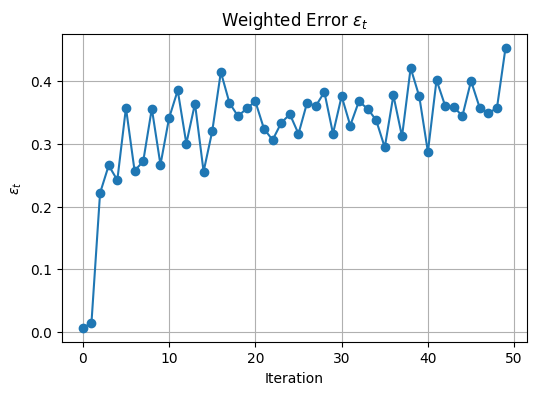

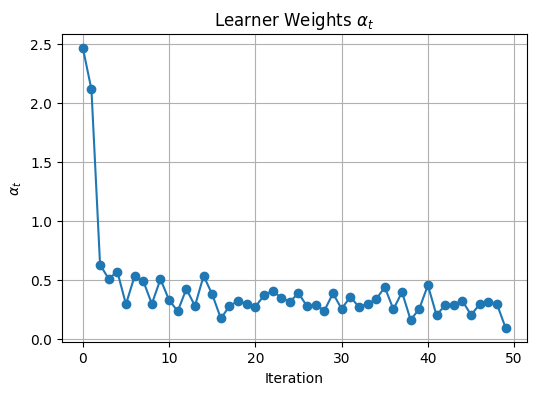

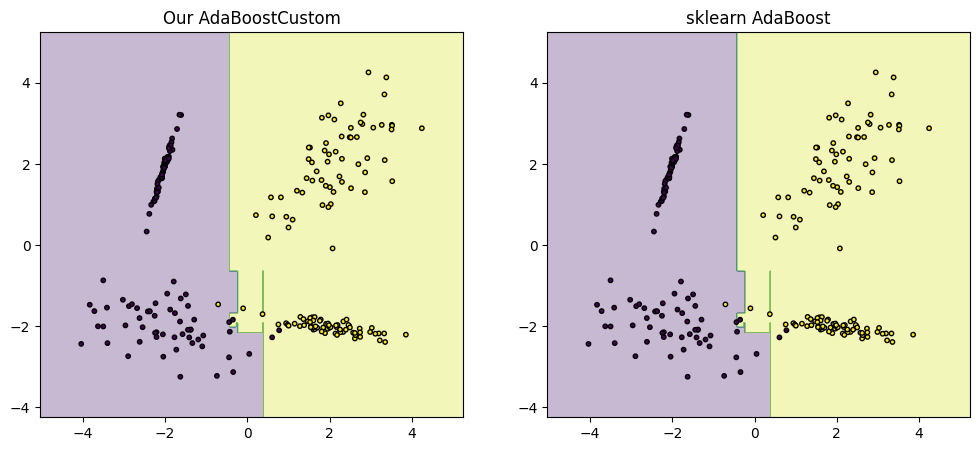

Test accuracy (sklearn): 0.9833


In [19]:
# Fit our AdaBoost
custom_model = AdaBoostCustom(T=50)
custom_model.fit(X_train, y_train)

# Evaluate accuracy
y_pred = custom_model.predict(X_test)
print(f"Test accuracy (ours): {accuracy_score(y_test, y_pred):.4f}")

# Inspect first few epsilon_t and alpha_t values
print("First 5 epsilons:", [f"{e:.4f}" for e in custom_model.epsilons[:5]])
print("First 5 alphas:",   [f"{a:.3f}" for a in custom_model.alphas[:5]])


# --- Plots ---
# Weighted error epsilon_t over iterations (should stay < 0.5)
plt.figure(figsize=(6,4))
plt.plot(custom_model.epsilons, marker='o')
plt.title(r"Weighted Error $\epsilon_t$")
plt.xlabel("Iteration"); plt.ylabel(r"$\epsilon_t$")
plt.grid(True); plt.show()

# Alpha values alpha_t (should increase when epsilon_t decreases)
plt.figure(figsize=(6,4))
plt.plot(custom_model.alphas, marker='o')
plt.title(r"Learner Weights $\alpha_t$")
plt.xlabel("Iteration"); plt.ylabel(r"$\alpha_t$")
plt.grid(True); plt.show()


# --- Sklearn comparison ---
sk_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)

# sklearn uses {0,1}, so convert
sk_model.fit(X_train, (y_train+1)//2)

# Decision boundary
def plot_decision_boundary(clf, X, y, ax=None, title="Decision boundary", grid_step=0.02):
    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    try:
        Z = np.sign(clf.decision_function(grid))
    except:
        Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:,0], X[:,1], c=(y>0).astype(int), s=10, edgecolor='k')
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(custom_model, X_test, y_test,
                       title="Our AdaBoostCustom", ax=axes[0])
plot_decision_boundary(sk_model, X_test, y_test,
                       title="sklearn AdaBoost", ax=axes[1])
plt.show()

sk_pred = sk_model.predict(X_test)
sk_acc = accuracy_score((y_test+1)//2, sk_pred)

print(f"Test accuracy (sklearn): {sk_acc:.4f}")

# Part 4 - Experimental Design and Analysis

## Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [ ]:
# Generate additional data sets

# Split data sets

In [ ]:
# Visualize data

In [5]:
custom_model = AdaBoostCustom(T=10)
sklearn_model = AdaBoostClassifier(n_estimators=10, random_state=42)

# Your code here

NameError: name 'AdaBoostClassifier' is not defined

## Test Algorithms
Test your AdaBoost, a library implementation of AdaBoost and at least two additional models, one of which must be another boosting algorithm on your two datasets.

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [8]:
# Set up models 

In [9]:
# Test and visualize

# Part 5 - Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 